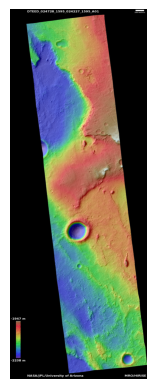

In [2]:
Product_ID = 'DTEED_024728_1595_024227_1595_A01'
img_path = 'data/DTM/' + Product_ID + '.IMG'
jpg_path = 'data/JPG/' + Product_ID + '.ca.jpg'
# 显示jpg
from PIL import Image

from matplotlib import pyplot as plt

img = Image.open(jpg_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  3497 x 10431 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3393833.2607584,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-20],PARAMETER["central_meridian",329.99],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -3537.394372595001 , -1204253.7512038578 )
Pixel Size = ( 2.0179089404421 , -2.0179089404421 )
ignore_value:  -3.4028226550889045e+38


In [4]:
# ignore_value用NAN替代
data[data == ignore_value] = np.NAN

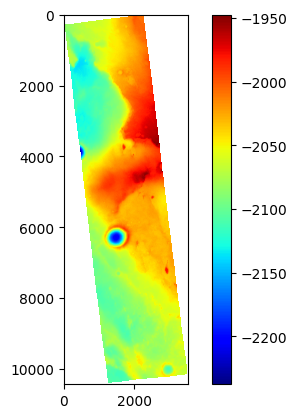

In [5]:
# data画图,带色条
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data, cmap='jet')
plt.colorbar()
plt.show()

In [1]:
# 划分方格
data_mask = np.isnan(data)
center = [int(data_mask.shape[0] / 2), int(data_mask.shape[1] / 2)]
# 取出最大区域全为true的区域
count = 1
while True:
    if np.all(data_mask[center[0] - count: center[0] + count, center[1] - count: center[1] + count] == False):
        count += 1
    else:
        count -= 1
        break
print(count)
data_cut = data[center[0] - count: center[0] + count, center[1] - count: center[1] + count]
plt.imshow(data_cut, cmap='rainbow')
plt.colorbar()

NameError: name 'np' is not defined

In [92]:
geotransform = dataset.GetGeoTransform()
if abs(geotransform[1]) != abs(geotransform[5]):
    print('warning: 两个方向上的距离间隔不一致')
map_scale = abs(geotransform[1])
actural_interval = 20  # m
interval = int(actural_interval / map_scale)
from scipy.ndimage import gaussian_filter1d


def filter_1d(dem, _interval):
    big_scale_dem = gaussian_filter1d(dem, sigma=_interval,mode='reflect')
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem, small_scale_dem

In [93]:
bs_1d, ss_1d = filter_1d(data_cut[0,:], interval)

In [94]:
%matplotlib notebook
plt.plot(bs_1d[:500],'b')
plt.plot(data_cut[0,:500], 'r')
plt.show()

<IPython.core.display.Javascript object>

In [95]:
%matplotlib notebook
plt.hist(ss_1d,bins=100)
plt.xlim(-2,2)
plt.show()

<IPython.core.display.Javascript object>

In [96]:
from scipy.ndimage import gaussian_filter

def filter_2d(dem, _interval):
    big_scale_dem = gaussian_filter(dem, sigma=_interval,mode='reflect')
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem, small_scale_dem

In [97]:
bs_2d, ss_2d = filter_2d(data_cut, interval)

In [98]:
%matplotlib notebook
plt.imshow(ss_2d,cmap='rainbow')
plt.colorbar()

<IPython.core.display.Javascript object>

In [99]:
#对比x轴第一条的bs_2d和ss_2d，和y轴第一条的bs_2d和ss_2d
%matplotlib notebook
plt.plot(bs_2d[0,:500],'b')
plt.plot(data_cut[0,:500],'r')
# plt.plot(bs_2d[:500,0],'g')
# plt.plot(data_cut[:500,0],'black')

<IPython.core.display.Javascript object>

In [100]:
%matplotlib notebook
plt.hist(ss_2d.flatten(),bins=1000)
plt.xlim(-2,2)

<IPython.core.display.Javascript object>

(-2.0, 2.0)

In [101]:
def RMSH(dem):
    dem_mean = np.nanmean(dem)
    rmsh = np.sqrt(np.nansum((dem - dem_mean) ** 2) / (np.sum(~np.isnan(dem)) - 1))
    return rmsh


rmsh_1d = np.zeros(data_cut.shape[0])
for i in range(data_cut.shape[0]):
    bs_1d, ss_1d = filter_1d(data_cut[i, :], interval)
    rmsh_1d[i] = RMSH(ss_1d)
rmsh_2d = RMSH(ss_2d)
print(np.mean(rmsh_1d), rmsh_2d)

0.2997887081163923 0.42203365851690217


In [102]:
autocorrelation_1d = np.ones((data_cut.shape[0], ss_2d.shape[0] - 1))
for i in range(data_cut.shape[0]):
    bs_1d, ss_1d = filter_1d(data_cut[i, :], interval)
    mean_1d = np.mean(ss_1d)
    temp1 = np.sum((ss_1d - mean_1d) ** 2)
    for j in range(0, ss_1d.shape[0] - 1):
        autocorrelation_1d[i][j] = np.sum(
            (ss_1d[0:ss_1d.shape[0] - j] - mean_1d) * (ss_1d[j:ss_1d.shape[0]] - mean_1d)) / temp1

autocorrelation_1d_max = np.max(autocorrelation_1d, axis=0)
autocorrelation_1d_min = np.min(autocorrelation_1d, axis=0)
autocorrelation_1d_mean = np.mean(autocorrelation_1d, axis=0)

In [103]:
%matplotlib notebook
plt.plot(autocorrelation_1d_max[:200],'b')
plt.plot(autocorrelation_1d_min[:200],'r')
plt.plot(autocorrelation_1d_mean[:200],'g')

<IPython.core.display.Javascript object>

In [104]:
from numpy.fft import fft2, ifft2, fftshift
def autocorrelation_2d(_dem):
    _mean_2d = np.nanmean(_dem)
    _Var_2d_1 = np.sum((_dem-_mean_2d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_2d = np.pad(_dem - _mean_2d, (_pad_size, _pad_size), 'constant')
    _fft_2d = fft2(_expanded_ss_2d)
    _fft_2d_conj = np.conj(_fft_2d)
    _F_prod = _fft_2d * _fft_2d_conj
    _rho_num = fftshift(ifft2(_F_prod)).real
    _autocorrelation_2d = _rho_num[_pad_size:-_pad_size, _pad_size:-_pad_size]/_Var_2d_1
    return _autocorrelation_2d

In [105]:
autocorrelation_2d_1 = autocorrelation_2d(ss_2d)
%matplotlib notebook
plt.imshow(autocorrelation_2d_1,cmap='rainbow')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>